# Import Modules

In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
import matplotlib.pyplot as plt

# Establish Sensor Array

Our sensor matrix, X, is an array that has an element for each observation, which includes the start and end times of the observation period and the x and y locations that the observation was taken at. Consider an array of four sensors in a grid that each take two time averaged readings. 

In [13]:
X = np.asarray([[2,3,3,3],[2,3,3,7],[2,3,7,3],[2,3,7,7], #[t_lower,t_upper,x_location,y_location]
               [8,9,3,3],[8,9,3,7],[8,9,7,3],[8,9,7,7]])

Text(0.5, 1.0, 'Sensor Locations')

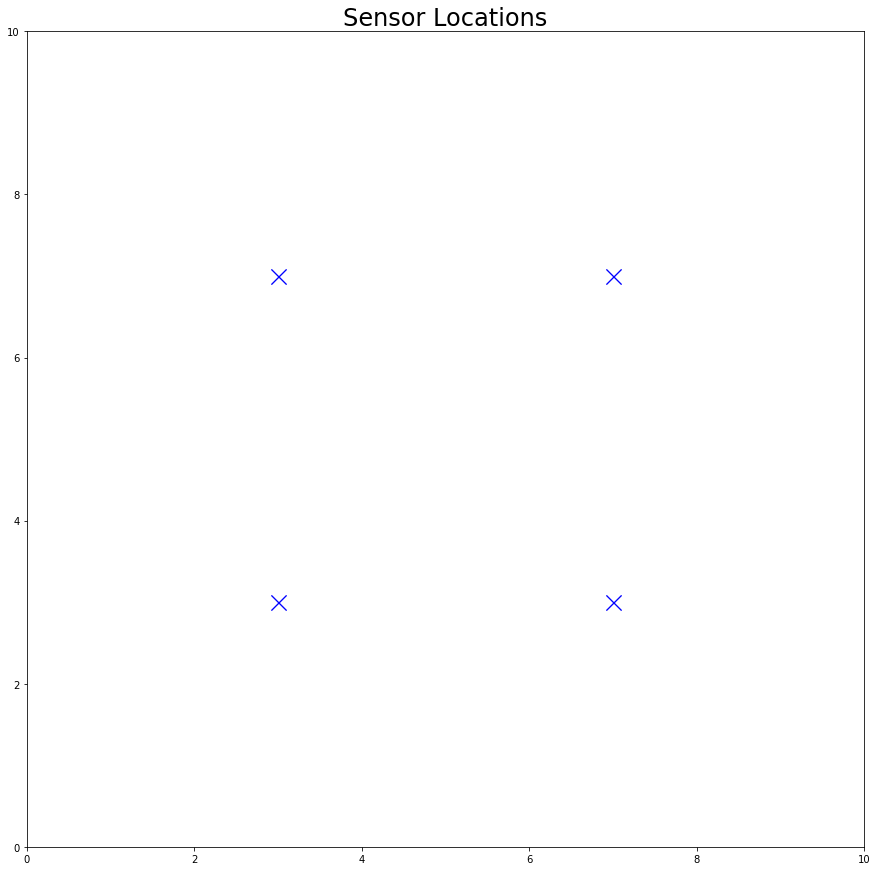

In [14]:
plt.plot(X[:,2],X[:,3],'xk',markersize=15,color='b')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title("Sensor Locations",fontsize=24)

Using X with then initalise our sensor model, which is used to calculate filter functions.

In [15]:
sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging (second argument)

# Forward Model Example

Here we generate an artificial source and concentration field using the tools in advectionGP.models. The source is generated over a 10x10x10 grid in space and time.

### Establish forward model parameters

In [16]:
k_0 = 0.01 #Diffusion coefficient
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
kForward = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
u=[]
u.append(np.ones(res)*0.01) #x direction wind
u.append(np.ones(res)*0.01) # y direction wind

### Initialise model and calculate ground truth source, concentration and observations

Here we use a source term calculated by approximating a gaussian process with an EQ kernel, but any source of the right dimensions can be used to simulate the forward problem.

In [17]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source
sourceGT = np.zeros(m.resolution)
sourceGT[:,7:11,7:11] = 10.0
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

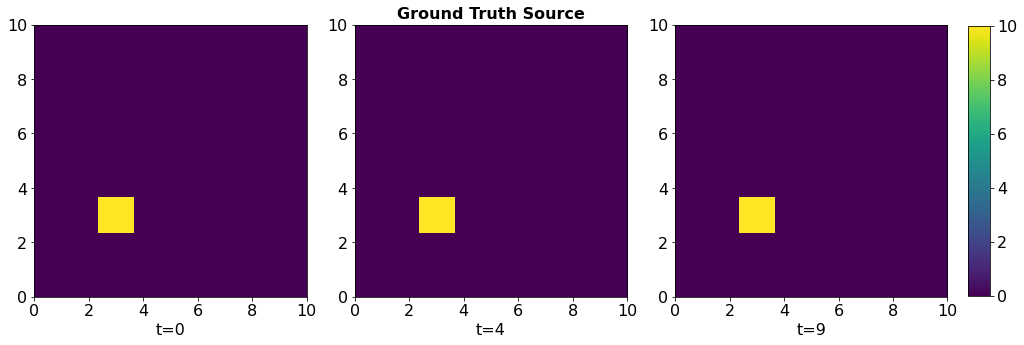

In [18]:
a=np.floor(np.min((np.min(sourceGT[[0,28,49]]))))
b=np.ceil(np.max((np.max(sourceGT[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Source'],[sourceGT]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

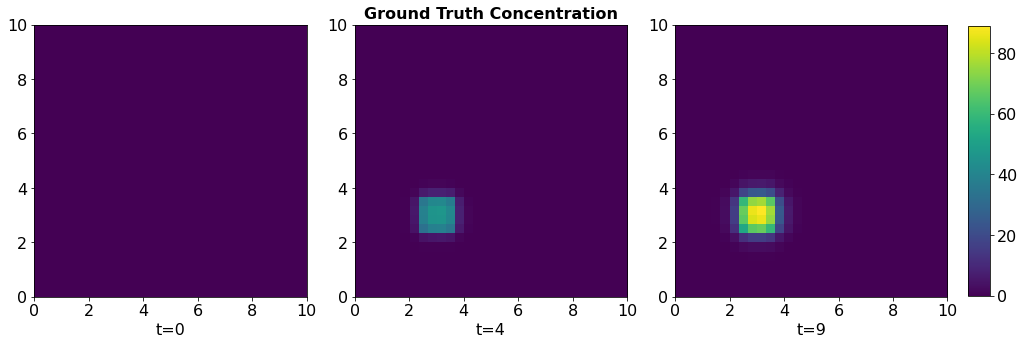

In [19]:
a=np.floor(np.min((np.min(concTrain[[0,28,49]]))))
b=np.ceil(np.max((np.max(concTrain[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Ground Truth Concentration'],[concTrain]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

# Inverse Problem Example

In [20]:
N_feat =200 #Number of features used to infer the source
kInverse = EQ(2, 2.0) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,u=u,k_0=k_0) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Calculating Adjoints...
7/8 
Calculating Phis...
199/200 


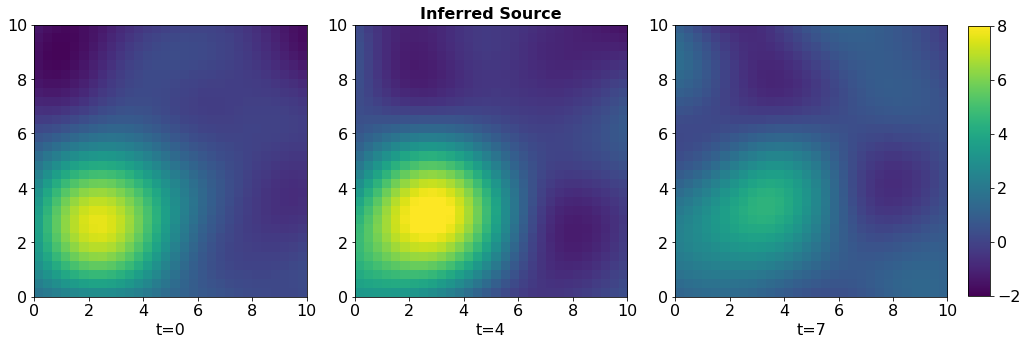

In [21]:
a=np.floor(np.min((np.min(sourceInfer[[0,28,49]]))))
b=np.ceil(np.max((np.max(sourceInfer[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Inferred Source'],[sourceInfer]):
    for t in [0,24,39]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

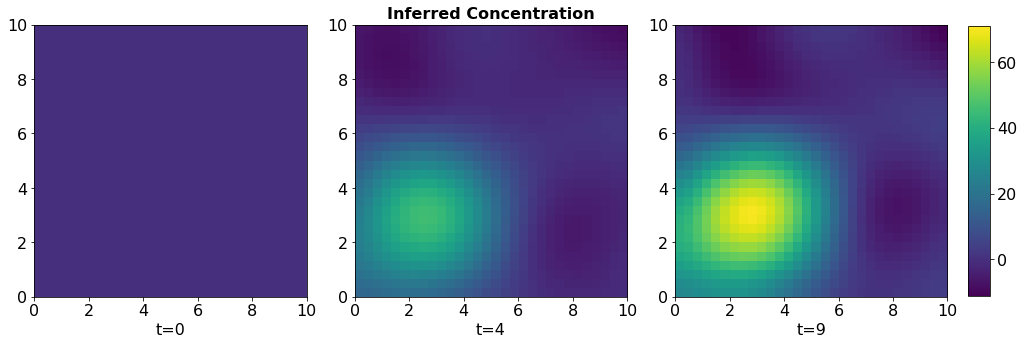

In [22]:
a=np.floor(np.min((np.min(concInfer[[0,28,49]]))))
b=np.ceil(np.max((np.max(concInfer[[0,28,49]]))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

ploti = 0
for title, data in zip(['Inferred Concentration'],[concInfer]):
    for t in [0,24,49]:
        ploti+=1
        plt.subplot(1,3,ploti)
        im1=plt.imshow(data[t], extent=[0,10,0,10],origin='lower') #fix t...
        time = t*dt
        plt.xlabel("t=%d" % time,fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.clim(a,b)
        
        
        tick_font_size = 16
        if ploti % 3 == 2: plt.title(title, fontsize=16, fontweight='bold')
        #if ploti % 3 == 3:
        #    plt.colorbar(im1,fraction=0.046, pad=0.04)

fig.tight_layout(rect=[0.1, 0.2, 1, 1])

cbar_ax = fig.add_axes([1, 0.475, 0.02, 0.25])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()